In [1]:
import hydra
import os
os.environ['MUJOCO_GL'] = 'egl'
import warnings
warnings.filterwarnings('ignore')
from hydra.core.hydra_config import HydraConfig
from omegaconf import OmegaConf
from huggingface_hub import HfFileSystem
from huggingface_hub import hf_hub_download
import torch.nn.functional as F
import gym
import h5py
import imageio
import numpy as np
import torch
from glob import glob
from tqdm.notebook import tqdm
from termcolor import colored
from pathlib import Path
from copy import deepcopy

from common.buffer import Buffer, RobomimicBuffer
from common.parser import parse_cfg
from common.seed import set_seed
from envs import make_env
from tdmpc2 import TDMPC2
from collections import defaultdict
from envs.wrappers.pixels import PixelWrapper

from tensordict import TensorDict
from mujoco import mjtVisFlag
from IPython.display import Video
from envs.myosuite import MYOSUITE_TASKS

import torchvision.transforms as transforms

In [7]:
def to_td(obs, action, reward=None):
    """Creates a TensorDict for a new episode."""
    if isinstance(obs, dict):
        obs = TensorDict(obs, batch_size=(), device='cpu')
    else:
        obs = obs.unsqueeze(0).cpu()
    if reward is None:
        reward = torch.tensor(float('nan'))
    td = TensorDict(dict(
        obs=obs.unsqueeze(0),
        action=action.unsqueeze(0),
        reward=torch.tensor(reward).unsqueeze(0),
    ), batch_size=(1,))
    return td


def evaluate(cfg): 
    success_only = cfg.success_only
    assert torch.cuda.is_available()
    assert cfg.eval_episodes > 0, 'Must evaluate at least 1 episode.'
    cfg = parse_cfg(cfg)
    set_seed(cfg.seed)
    print(colored(f'Task: {cfg.task}', 'blue', attrs=['bold']))
    print(colored(f'Model size: {cfg.get("model_size", "default")}', 'blue', attrs=['bold']))
    print(colored(f'Checkpoint: {cfg.checkpoint}', 'blue', attrs=['bold']))
    if not cfg.multitask and ('mt80' in cfg.checkpoint or 'mt30' in cfg.checkpoint):
        print(colored('Warning: single-task evaluation of multi-task models is not currently supported.', 'red', attrs=['bold']))
        print(colored('To evaluate a multi-task model, use task=mt80 or task=mt30.', 'red', attrs=['bold']))

    # Make environment
    env = make_env(cfg)
    buffer = RobomimicBuffer(cfg)

    # Load agent
    agent = TDMPC2(cfg)
    assert os.path.exists(cfg.checkpoint), f'Checkpoint {cfg.checkpoint} not found! Must be a valid filepath.'
    agent.load(cfg.checkpoint)
    
    # Evaluate
    if cfg.multitask:
        print(colored(f'Evaluating agent on {len(cfg.tasks)} tasks:', 'yellow', attrs=['bold']))
    else:
        print(colored(f'Evaluating agent on {cfg.task}:', 'yellow', attrs=['bold']))
    if cfg.save_video:
        video_dir = os.path.join(cfg.work_dir, 'videos')
        os.makedirs(video_dir, exist_ok=True)
    scores = []
    tasks = cfg.tasks if cfg.multitask else [cfg.task]
    for task_idx, task in enumerate(tasks):
        if not cfg.multitask:
            task_idx = None
        ep_rewards, ep_successes = [], []
        for i in range(cfg.eval_episodes):
            obs, done, ep_reward, t = env.reset(task_idx=task_idx), False, 0, 0
            obs_dict = {"vec_obs": obs,  "success": False, "fixed_camera": env.render()}
            _tds = [to_td(obs_dict, torch.zeros_like(env.rand_act()), ep_reward)]
            if cfg.save_video:
                frames = [env.render()]
            while not done:
                action = agent.act(obs, t0=t==0, task=task_idx)
                obs, reward, done, info = env.step(action)
                obs_dict = {"vec_obs": obs,  "success": np.array(info["solved"], dtype=bool), "fixed_camera": env.render()}
                _tds.append(to_td(obs_dict, action.flatten(), reward))
                ep_reward += reward
                t += 1
                if cfg.save_video:
                    frames.append(env.render())
            
            if success_only and info["success"] or not success_only:
                buffer.add(torch.cat(_tds))

            ep_rewards.append(ep_reward)
            ep_successes.append(info['success'])
            if cfg.save_video:
                imageio.mimsave(
                    os.path.join(video_dir, f'{task}-{i}.mp4'), frames, fps=15)
        buffer.save(cfg.hdf5_save_path)
        ep_rewards = np.mean(ep_rewards)
        ep_successes = np.mean(ep_successes)
        if cfg.multitask:
            scores.append(ep_successes*100 if task.startswith('mw-') else ep_rewards/10)
        print(colored(f'  {task:<22}' \
            f'\tR: {ep_rewards:.01f}  ' \
            f'\tS: {ep_successes:.02f}', 'yellow'))
    if cfg.multitask:
        print(colored(f'Normalized score: {np.mean(scores):.02f}', 'yellow', attrs=['bold']))
    return buffer

def get_task(x):
    x = x.split('/')[-1]
    x = '-'.join(['myo'] + x.split('-')[2:-1]).rstrip('.pt')
    return x


def load_data(cfg):
    # Load data
    assert cfg.task in cfg.data_dir, \
        f'Expected data directory {cfg.data_dir} to contain {cfg.task}, ' \
        f'please double-check your config.'

    # Create buffer for sampling
    _cfg = deepcopy(cfg)
    if _cfg.task.startswith("mt"):
        _cfg.episode_length = 101 if cfg.task == 'mt80' else 501
        _cfg.buffer_size = 550_450_000 if cfg.task == 'mt80' else 345_690_000
        buffer = Buffer(_cfg)
        fp = Path(os.path.join(cfg.data_dir, '*.pt'))
        fps = sorted(glob(str(fp)))
    elif _cfg.task.startswith("myo"):
        _cfg.episode_length = 101
        _cfg.buffer_size = 100_000
        buffer = RobomimicBuffer(_cfg)
        fp = Path(os.path.join(cfg.data_dir, '*.hdf5'))
        fps = sorted(fp.rglob('*.hdf5'))
    _cfg.steps = _cfg.buffer_size
    
    assert len(fps) > 0, f'No data found at {fp}'
    print(f'Found {len(fps)} files in {fp}')

    for fp in tqdm(fps, desc='Loading data'):
        if _cfg.task.startswith("mt"):
            td = torch.load(fp)
            assert td.shape[1] == _cfg.episode_length, \
                f'Expected episode length {td.shape[1]} to match config episode length {_cfg.episode_length}, ' \
                f'please double-check your config.'
            for i in range(len(td)):
                buffer.add(td[i])
        else:
            td = buffer.load_hdf5(fp)

    assert buffer.num_eps == buffer.capacity, \
        f'Buffer has {buffer.num_eps} episodes, expected {buffer.capacity} episodes.'

    return buffer


In [ ]:
buffer = evaluate(cfg)
f = h5py.File("test.hdf5", 'w')
buffer._buffer.storage[buffer._buffer.storage['episode'] == 0]

buffer.save_hdf5('test.h5')

NameError: name 'cfg' is not defined

## Download checkpoints from huggingface

In [7]:
repo_id = "nicklashansen/tdmpc2"
subfolder = "myosuite"

# List of checkpoint filenames to download
fs = HfFileSystem()

checkpoint_files = map(lambda x: x.split('/')[-1], fs.glob(f"{repo_id}/myosuite/*.pt"))

myo_ckpts = []
# Download each checkpoint
for file_name in checkpoint_files:
    file_path = hf_hub_download(repo_id, filename=file_name, subfolder=subfolder)
    print(f"Downloaded {file_name} to {file_path}")
    myo_ckpts.append(file_path)

subfolder_path = os.path.split(myo_ckpts[0])[0]

# subfolder = "dmcontrol"

# checkpoint_files = ['dog-run-1.pt']

# dmcontrol_ckpts = []

# for file_name in checkpoint_files:
#     file_path = hf_hub_download(repo_id, filename=file_name, subfolder=subfolder)
#     print(f"Downloaded {file_name} to {file_path}")
#     dmcontrol_ckpts.append(file_path)


Downloaded myo-hand-key-turn-1.pt to /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-key-turn-1.pt
Downloaded myo-hand-key-turn-2.pt to /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-key-turn-2.pt
Downloaded myo-hand-key-turn-3.pt to /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-key-turn-3.pt
Downloaded myo-hand-key-turn-hard-1.pt to /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-key-turn-hard-1.pt
Downloaded myo-hand-key-turn-hard-2.pt to /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-key-turn-hard-2.pt
Downloaded myo-hand-key-turn-hard-3

## Load checkpoint scores

In [10]:
ckpt_scores = defaultdict(list)

for ckpt in myo_ckpts: 
    with hydra.initialize(config_path='.'):
        cfg = hydra.compose('config.yaml',
                            return_hydra_config=True,
                            overrides=[f'task={get_task(ckpt)}', 
                                        'hydra/launcher=basic',
                                        '+success_only=true',
                                       f'checkpoint={ckpt}'])
        HydraConfig.instance().set_config(cfg)
        cfg = parse_cfg(cfg)
    ckpt_scores[get_task(ckpt)].append(evaluate(cfg))



Task: myo-key-turn
Model size: default
Checkpoint: /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-key-turn-1.pt
Evaluating agent on myo-key-turn:
Buffer capacity: 1,000,000
Storage required: 12.83 GB
Using CPU memory for storage.


KeyboardInterrupt: 

In [8]:
# ckpt = myo_ckpts[0]
ckpt = " /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-pose-hard-1.pt"
with hydra.initialize(config_path='.'):
    cfg = hydra.compose('config.yaml',
                        return_hydra_config=True,
                        overrides=[f'task={get_task(ckpt)}', 
                                    'hydra/launcher=basic',
                                    f'checkpoint={ckpt}',
                                    f'buffer_size=1_000_000',
                                    'save_video=true'])
    HydraConfig.instance().set_config(cfg)
    cfg = parse_cfg(cfg)
    env = make_env(cfg)
    print(f"{cfg.task} ep len", env.env._max_episode_steps)

# evaluate(cfg)

MyoSuite:> Registering Myo Envs
    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    
myo-pose-hard ep len 100


In [8]:
env = make_env(cfg)
buffer = RobomimicBuffer(cfg)
cfg.buffer_size = 100_000
data_path = "/home/krishnans/ngc/tdmpc2/datasets/myo-pose-hard/myo-pose-hard_500.hdf5"
# buffer.load_hdf5(data_path)

cfg.buffer_size = 100_000
transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((64, 64)),
                        transforms.ToTensor()
                    ])

# Load agent
agent = TDMPC2(cfg)
assert os.path.exists(cfg.checkpoint), f'Checkpoint {cfg.checkpoint} not found! Must be a valid filepath.'
agent.load(cfg.checkpoint)


with h5py.File(data_path, "r") as f:
    for episode_id in range(len(f["data"])):
        episode_group = f[f"data/demo_{episode_id}"]
        num_samples = episode_group.attrs["num_samples"]
        episode_td = {}
        episode_transitions = []
        for key in episode_group.keys():
            if isinstance(episode_group[key], h5py.Group):
                sub_dict = {}
                for sub_key in episode_group[key].keys():
                    if sub_key == 'fixed_camera':
                        sub_dict[sub_key] = torch.stack([transform(img) for img in episode_group[key][sub_key][:]])
                    else:
                        sub_dict[sub_key] = torch.tensor(episode_group[key][sub_key][:])
                episode_td[key] = TensorDict(sub_dict, batch_size=(num_samples,))
            else:
                episode_td[key] = torch.tensor(episode_group[key][:])
        episode_td = TensorDict(episode_td, batch_size=(num_samples,))
        buffer.add(episode_td)


Buffer capacity: 100,000
Storage required: 4.98 GB
Using CUDA memory for storage.


In [5]:
data_dir = list(Path("/home/krishnans/ngc/tdmpc2/datasets").rglob("*.hdf5"))

transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((64, 64)),
                        transforms.ToTensor()
                    ])

max_vec_obs_dim = 0
max_action_dim = 0
for fp in data_dir:
    with h5py.File(str(fp), 'r') as f:
        episode_id = 0
        if "vec_obs" in f[f"data/demo_{episode_id}"]:
            vec_obs_group = f[f"data/demo_{episode_id}/vec_obs"]
            for vec_obs_key in vec_obs_group.keys():
                vec_obs_shape = vec_obs_group[vec_obs_key].shape
                if len(vec_obs_shape) > 1 and vec_obs_shape[1] > max_vec_obs_dim:
                    max_vec_obs_dim = vec_obs_shape[1]
        if "action" in f[f"data/demo_{episode_id}"]:
            action_shape= f[f"data/demo_{episode_id}/action"].shape
            if len(action_shape) > 1 and action_shape[1] > max_action_dim:
                max_action_dim = action_shape[1]

pad_vec_obs = transforms.Lambda(lambda x: F.pad(input=x, pad=(0, max_vec_obs_dim - x.shape[1]), mode='constant', value=0))
pad_action = transforms.Lambda(lambda x: F.pad(input=x, pad=(0, max_action_dim - x.shape[1]), mode='constant', value=0))

cfg.buffer_size = 90_000
buffer = RobomimicBuffer(cfg)
for fp in data_dir:
    f = h5py.File(str(fp), 'r')
    for episode_id in range(len(f["data"])):
        episode_group = f[f"data/demo_{episode_id}"]
        num_samples = episode_group.attrs["num_samples"]
        episode_td = {}
        episode_transitions = []
        for key in episode_group.keys():
            if isinstance(episode_group[key], h5py.Group):
                sub_dict = {}
                for sub_key in episode_group[key].keys():
                    if sub_key == 'fixed_camera':
                        sub_value = torch.stack([transform(img) for img in episode_group[key][sub_key][:]])
                    if sub_key == 'vec_obs':
                        sub_value = pad_vec_obs(torch.tensor(episode_group[key][sub_key][:]))
                    else:
                        sub_value = torch.tensor(episode_group[key][sub_key][:])
                    sub_dict[sub_key] = sub_value
                episode_td[key] = TensorDict(sub_dict, batch_size=(num_samples,))
            else:
                if key == 'action':
                    episode_td[key] = pad_action(torch.tensor(episode_group[key][:]))
                else:
                    episode_td[key] = torch.tensor(episode_group[key][:])
        episode_transitions = TensorDict(episode_td, batch_size=(num_samples,))
        buffer.add(episode_transitions)

Buffer capacity: 50,000
Storage required: 22.13 GB
Using CPU memory for storage.


In [ ]:
cfg.data_dir = "/home/krishnans/ngc/tdmpc2/datasets"
load_data(cfg)

In [2]:
import matplotlib.pyplot as plt

In [ ]:
buffer.load_hdf5("/home/krishnans/ngc/tdmpc2/datasets/myo-pose-hard_500.hdf5")

In [5]:
# Display the video in the Jupyter notebook
Video(str(list((cfg.work_dir / 'videos').iterdir())[1]))

In [3]:
import mujoco

## Render clean images from env

In [4]:
from gym import spaces


class MyoSuiteCameraWrapper(gym.Wrapper):
    def __init__(self, env, frame_size=(244, 244), camera_names=['hand_side_inter']):
        super().__init__(env)
        self.env = env
        self.frame_size = frame_size
        self.camera_names = camera_names
        self.camera_observation_space = spaces.Dict({
            cam_name: spaces.Box(0, 255, (*frame_size, 3), dtype=np.uint8)
            for cam_name in self.camera_names
        })
        self.has_rendered = False

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        info.update(self.get_camera_obs())
        info['success'] = info['solved']
        return obs, reward, done, info

    def get_camera_obs(self):
        if not self.has_rendered: 
            self.env.sim.renderer.render_offscreen(width=self.frame_size[0], height=self.frame_size[1], camera_id=-1)
            self.has_rendered = True
            self.env.sim.renderer._scene_option.flags[mjtVisFlag.mjVIS_STATIC] = 0
        return {cam_name: self.env.sim.renderer.render_offscreen(
            width=self.frame_size[0], height=self.frame_size[1],
            camera_id=cam_name) for cam_name in self.camera_names
            }

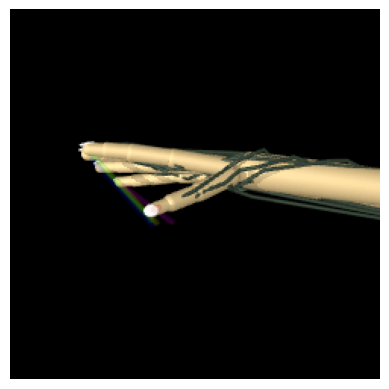

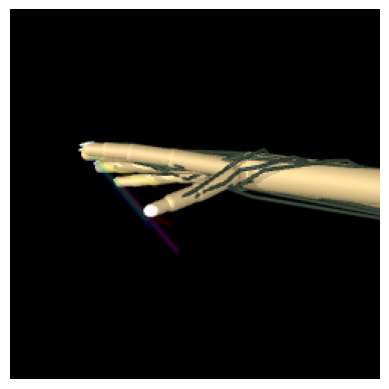

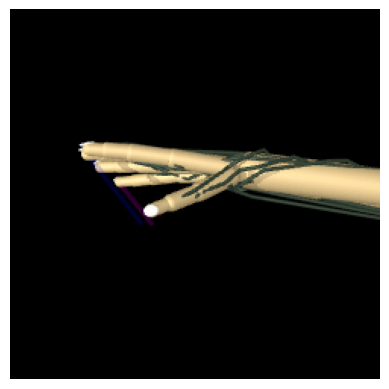

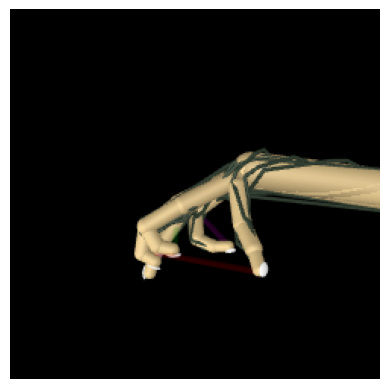

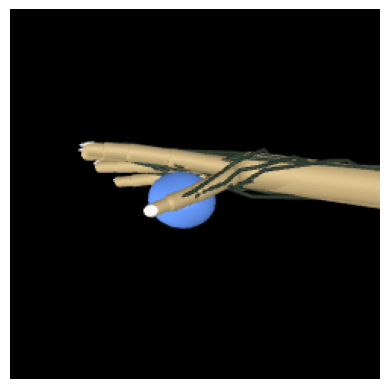

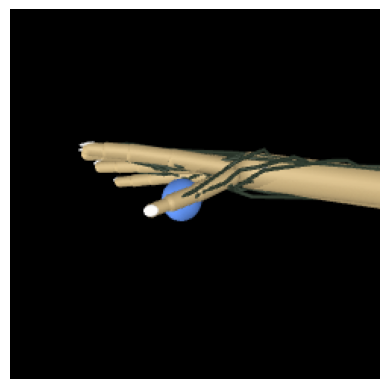

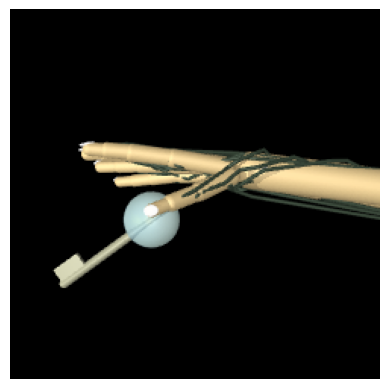

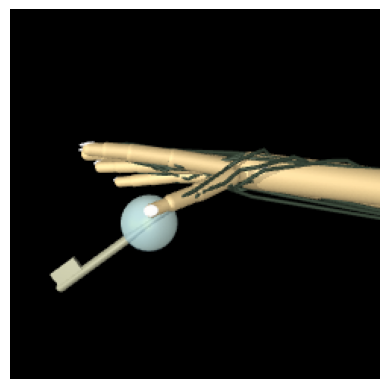

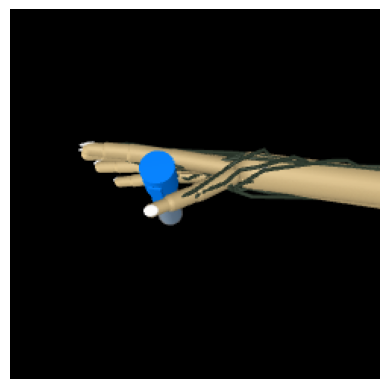

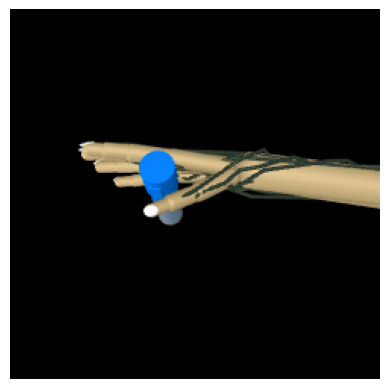

In [17]:
MYOSUITE_TASKS = {
	'myo-reach': 'myoHandReachFixed-v0',
	'myo-reach-hard': 'myoHandReachRandom-v0',
	'myo-pose': 'myoHandPoseFixed-v0',
	'myo-pose-hard': 'myoHandPoseRandom-v0',
	'myo-obj-hold': 'myoHandObjHoldFixed-v0',
	'myo-obj-hold-hard': 'myoHandObjHoldRandom-v0',
	'myo-key-turn': 'myoHandKeyTurnFixed-v0',
	'myo-key-turn-hard': 'myoHandKeyTurnRandom-v0',
	'myo-pen-twirl': 'myoHandPenTwirlFixed-v0',
	'myo-pen-twirl-hard': 'myoHandPenTwirlRandom-v0',
}

for env_name in MYOSUITE_TASKS.values():
    env = MyoSuiteCameraWrapper(gym.make(env_name))
    env.reset()
    cam_obs = env.get_camera_obs()
    image = cam_obs['hand_side_inter']
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f'{env_name}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

In [9]:
wrapped_env = MyoSuiteCameraWrapper(env.env.env.env.env)

In [16]:
model_ckpt_dir = "/home/krishnans/"

NameError: name 'model_ckpt_dir' is not defined

In [ ]:
# ckpt = myo_ckpts[0]
ckpt = " /home/krishnans/.cache/huggingface/hub/models--nicklashansen--tdmpc2/snapshots/8fb2a82efb3bae96941da440128fe1332e4394fd/myosuite/myo-hand-pose-hard-1.pt"
with hydra.initialize(config_path='.'):
    cfg = hydra.compose('config.yaml',
                        return_hydra_config=True,
                        overrides=[f'task={get_task(ckpt)}', 
                                    'hydra/launcher=basic',
                                    f'checkpoint={ckpt}',
                                    f'buffer_size=1_000_000',
                                    'save_video=true'])
    HydraConfig.instance().set_config(cfg)
    cfg = parse_cfg(cfg)
    env = make_env(cfg)
    print(f"{cfg.task} ep len", env.env._max_episode_steps)

# evaluate(cfg)

In [10]:
obs = wrapped_env.reset()

In [11]:
cam_obs = wrapped_env.get_camera_obs()

import matplotlib.pyplot as plt

image = cam_obs['hand_side_inter']
plt.imshow(image)
plt.axis('off')
plt.savefig('hand_side_inter.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [18]:
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [5]:
list(Path("/home/krishnans/ngc/bidex_datasets/").rglob("*500.hdf5"))

[PosixPath('/home/krishnans/ngc/bidex_datasets/switch/rollouts_500.hdf5'),
 PosixPath('/home/krishnans/ngc/bidex_datasets/scissors/rollouts_500.hdf5')]

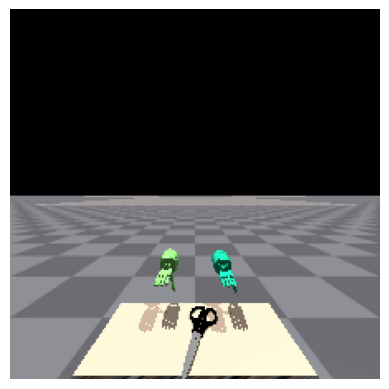

In [20]:
f = h5py.File("/home/krishnans/ngc/bidex_datasets/scissors/rollouts_500.hdf5")
cam_obs = list(filter(lambda x: 'camera' in x, f['data/demo_0/obs'].keys()))
for obs_key in cam_obs:
    data = f[f'data/demo_0/obs/{obs_key}'][:][0].astype(np.uint8)
    plt.imshow(data)
    plt.axis('off')
    plt.savefig(f'{obs_key}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()